## Problem statement: 
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import shutil
import zipfile
from glob import glob
tf.get_logger().setLevel('ERROR')

In [2]:
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
USE_GDRIVE=False
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
    USE_GDRIVE=True
except:
    print("google colab not found")    
    

google colab not found


In [4]:
if USE_GDRIVE == False:
    try :
        shutil.rmtree('dataset')
        
    except:
        print("Data directory not found")
    with zipfile.ZipFile("CNN_assignment.zip", 'r') as zip_ref:
        zip_ref.extractall(".")
    


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [5]:
if USE_GDRIVE == True:
    root_dir="/content/"
    dataset_dir=root_dir+"Skin cancer ISIC The International Skin Imaging Collaboration/"
else :
    root_dir="./"
    dataset_dir=root_dir+"Skin cancer ISIC The International Skin Imaging Collaboration/"

In [6]:
##remove space from name for augmentor
if USE_GDRIVE == False:
    dataset_dir_updated=root_dir+"dataset/"
    os.rename(dataset_dir,dataset_dir_updated)

In [7]:
dataset_train_path=dataset_dir_updated+"Train"
dataset_test_path=dataset_dir_updated+"Test"

In [8]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path(root_dir+dataset_train_path)
data_dir_test = pathlib.Path(root_dir+dataset_test_path)
print(data_dir_train)

dataset\Train


In [9]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [10]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [11]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(directory=data_dir_train,
                                                       image_size=(img_height, img_height),
                                                      validation_split=0.2,subset='training',
                                                       label_mode='categorical',
                                                      seed=123)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [12]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.utils.image_dataset_from_directory(directory=data_dir_train,
                                                       image_size=(img_height, img_height),
                                                      validation_split=0.2,subset='validation',
                                                     label_mode='categorical',
                                                      seed=123)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [13]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)
num_classes=len(class_names)
print(num_classes)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
9


### Visualize the data

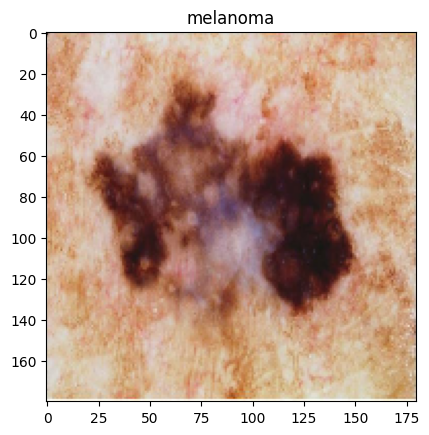

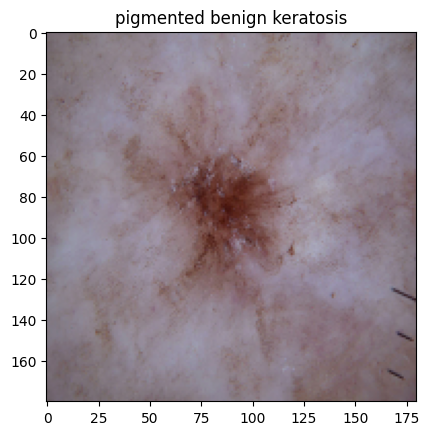

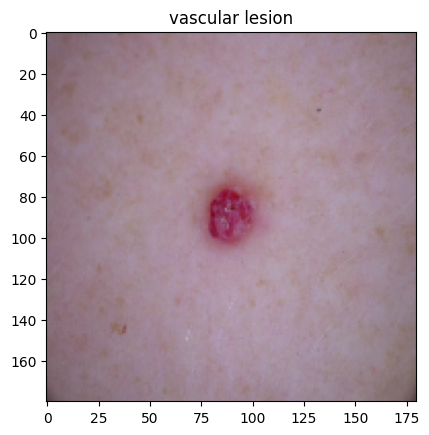

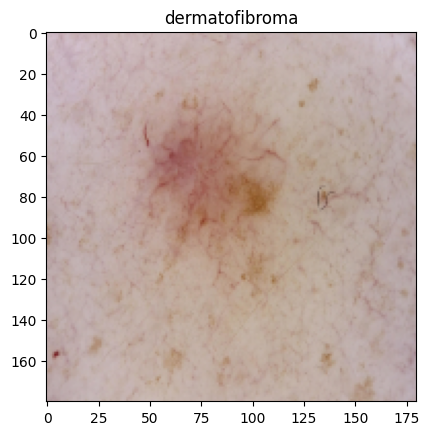

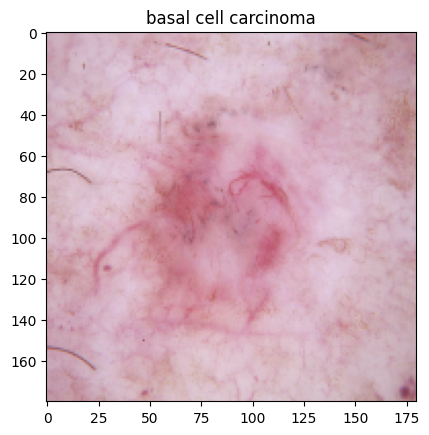

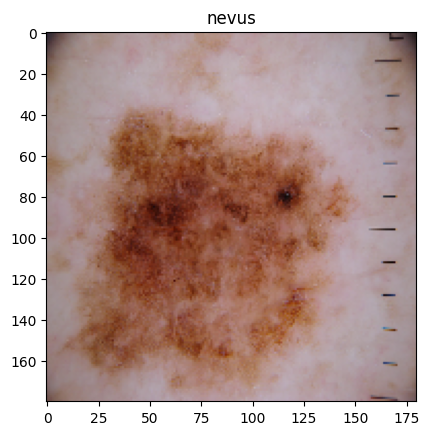

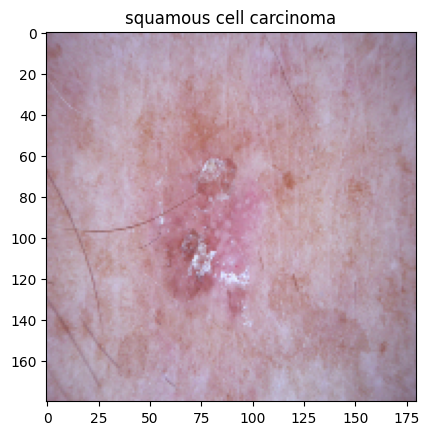

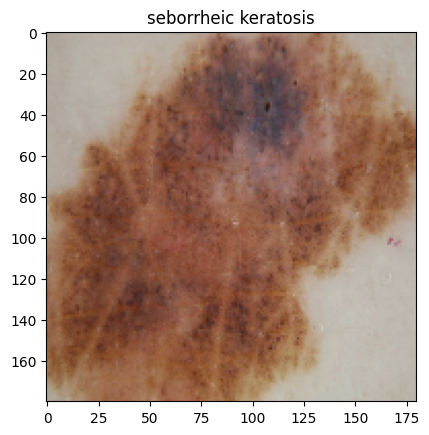

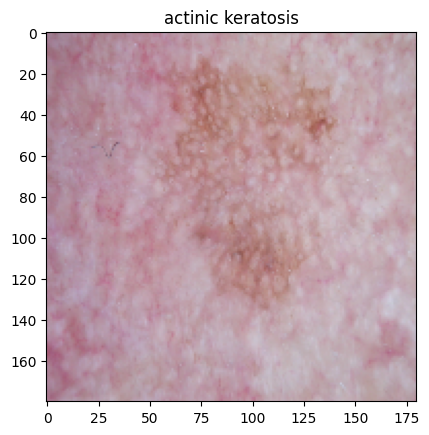

In [14]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
data_iter=iter(val_ds)
s=set()

while len(s)<9:
    d,l=next(data_iter)  
   # print(l.numpy())
    for i in range(0,32):  
        for j in range(0,num_classes):
            t=l[i].numpy()[j]
            if(t==1):
                if j not in s:
                    s.add(j)
                    plt.figure()
                    plt.title(class_names[j])
                    plt.imshow(d[i].numpy().astype(np.uint8))
                    
       
    



The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model


In [16]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras import layers

In [17]:
data_rescale = tf.keras.Sequential([
  layers.Rescaling(1./255)
])

In [18]:
### Your code goes here
model = Sequential()
model.add(keras.Input(shape=(img_height, img_width, 3)))
model.add(data_rescale)

model.add(Conv2D(32, (3, 3), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(512, (3, 3), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())

model.add(Dense(512,activation='relu'))

model.add(Dense(len(class_names),activation='softmax'))


In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 128)      

In [20]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Train the model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 14s 94ms/step - loss: 2.0781 - accuracy: 0.2188 - val_loss: 1.9525 - val_accuracy: 0.1790
Epoch 2/20
56/56 [==============================] - 4s 65ms/step - loss: 1.8531 - accuracy: 0.3064 - val_loss: 1.7110 - val_accuracy: 0.3378
Epoch 3/20
56/56 [==============================] - 4s 66ms/step - loss: 1.7135 - accuracy: 0.3705 - val_loss: 1.6015 - val_accuracy: 0.4161
Epoch 4/20
56/56 [==============================] - 4s 64ms/step - loss: 1.6128 - accuracy: 0.4235 - val_loss: 1.5363 - val_accuracy: 0.4720
Epoch 5/20
56/56 [==============================] - 4s 64ms/step - loss: 1.5333 - accuracy: 0.4593 - val_loss: 1.5650 - val_accuracy: 0.4430
Epoch 6/20
56/56 [==============================] - 4s 64ms/step - loss: 1.4939 - accuracy: 0.4676 - val_loss: 1.5129 - val_accuracy: 0.4497
Epoch 7/20
56/56 [==============================] - 4s 65ms/step - loss: 1.3974 - accuracy: 0.5134 - val_loss: 1.3952 - val_accuracy: 0.5123
Epoch 8/20
5

### Visualizing training results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### The model is overfitting because
   - Validation loss is increasing after few ( 10 ) epochs
   - There is huge gap between training and valiation accuracies

###  Lets add random rotaion and flipping as augmentation strategy

In [ ]:


data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical",seed=123),
  layers.RandomRotation(0.2,seed=123),
  layers.RandomZoom(0.2,seed=123)
  
])

### Visualize augmentation

In [ ]:
#tf.get_logger().setLevel('ERROR')

for image,label in train_ds.take(1):
    plt.title("Original Image")
    plt.imshow(image[0].numpy().astype(np.uint8))   
    plt.figure(figsize=(10, 10))
    for i in range(9):
        augmented_image = data_augmentation(image,training=True)
        ax = plt.subplot(3, 3, i + 1)  
        plt.title("Augmented Image")
        plt.imshow(augmented_image[0].numpy().astype(np.uint8))
        plt.axis("off")

#### As previous model is also overfitted lets add dropout layer



In [ ]:
model_2 = Sequential()
model_2.add(keras.Input(shape=(img_height, img_width, 3)))

model_2.add(data_augmentation)
model_2.add(data_rescale)

model_2.add(Conv2D(32, (3, 3), padding='same',activation='relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

model_2.add(Conv2D(64, (3, 3), padding='same',activation='relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

model_2.add(Conv2D(128, (3, 3), padding='same',activation='relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

model_2.add(Conv2D(256, (3, 3), padding='same',activation='relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))


model_2.add(Conv2D(512, (3, 3), padding='same',activation='relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))


model_2.add(Flatten())
model_2.add(Dense(512,activation='relu'))
model_2.add(Dropout(0.5))

model_2.add(Dense(len(class_names),activation='softmax'))



### Compiling the model

In [ ]:
### Todo, choose an appropirate optimiser and loss function
model_2.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model_2.summary()

### Training the model

In [ ]:
epochs = 20
history = model_2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

### Visualizing the results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings 
- After adding dropout and augementation model is no more overfit. Training accuracy and validation accuracy is closer
- However the model training accuracy dropped a lot. model seems to be overfit
- need to verify data for class imbalance

In [ ]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
dataframe_dict = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])
original_df['Label'].value_counts()
dataframe_dict = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])
original_df['Label'].value_counts()

####  seborrheic keratosis has the list number of samples (77)

#### pigmented benign keratosis domintaes the data in terms of number of samples

### Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
path_to_training_dataset=dataset_train_path+"/"
print(path_to_training_dataset)
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.flip_random(0.5)
    #p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)   
    #p.zoom(probability=0.5, min_factor=0.8, max_factor=1.2)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
from glob import glob
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
len(path_list_new)

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
len(lesion_list_new)

In [ ]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
#new_df = original_df.append(df2)
df2

In [ ]:
original_df['Label'].value_counts()

In [ ]:

new_df = original_df.append(df2)

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

In [ ]:
new_df['Label'].value_counts()

### Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

####  Create a training dataset

In [ ]:
data_dir_train=dataset_train_path
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='categorical')

#### Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size,
label_mode='categorical')

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create  model 

In [ ]:
initializer = tf.keras.initializers.HeUniform(seed=123)
model_3 = Sequential()
model_3.add(keras.Input(shape=(img_height, img_width, 3)))

model_3.add(data_augmentation) 
model_3.add(data_rescale)

model_3.add(Conv2D(32, (3, 3), padding='same',activation='relu',kernel_initializer=initializer))
#model_3.add(BatchNormalization())
model_3.add(MaxPooling2D(pool_size=(2, 2)))

model_3.add(Conv2D(64, (3, 3), padding='same',activation='relu',kernel_initializer=initializer))
#model_3.add(BatchNormalization())
model_3.add(MaxPooling2D(pool_size=(2, 2)))

model_3.add(Conv2D(128, (3, 3), padding='same',activation='relu',kernel_initializer=initializer))
#model_3.add(BatchNormalization())
model_3.add(MaxPooling2D(pool_size=(2, 2)))

model_3.add(Conv2D(256, (3, 3), padding='same',activation='relu',kernel_initializer=initializer))
#model_3.add(BatchNormalization())
model_3.add(MaxPooling2D(pool_size=(2, 2)))

model_3.add(Conv2D(512, (3, 3), padding='same',activation='relu',kernel_initializer=initializer))
#model_3.add(BatchNormalization())
model_3.add(MaxPooling2D(pool_size=(2, 2)))



model_3.add(Flatten())



model_3.add(Dense(512,activation='relu',kernel_initializer=initializer))
model_3.add(Dropout(0.5))

model_3.add(Dense(len(class_names),activation='softmax'))

####  Compile  model 

In [ ]:
model_3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model_3.summary()

In [ ]:

epochs = 50
## Your code goes here, use 50 epochs.
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.00001)
history = model_3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[reduce_lr]
)

In [ ]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

- Model losss decreased and model accuracy increased
- handling data imbalances help in addressing model underfitting and theryby increasing validation and train accuracy
- Loss is still decreasing . More epoch need to be trained or model need to be prepared for faster convergence

### Check model performance on test data

In [ ]:
test_ds=tf.keras.preprocessing.image_dataset_from_directory(data_dir_test,image_size=(img_width,img_height),
                                                            shuffle=False,batch_size=120)
predictions=model_3.predict(test_ds)
score = tf.nn.softmax(predictions)
_, labels = tuple(zip(*test_ds))
print()
print(np.argmax(score,axis=-1))
print()

from sklearn.metrics import accuracy_score
print('Test Accuracy')
accuracy_score(labels[0].numpy(),np.argmax(score,axis=-1))

### Test accuracy is poor. Need better model and strategy for improving test accuracy